/var/folders/c2/_ty3rvj17tgbd921xp37yxxw0000gn/T/ipykernel_4139/3825102951.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp = yf.download("^GSPC", start="2007-01-01", end="2024-01-01", progress=False)


[INFO] Loaded real market shock series: (4277, 1)
[INFO] Belief log loaded. Columns: Index(['user_id', 'belief', 'attitude'], dtype='object')
Training GNN Teacher...
[GNN] Epoch 000 | Loss 1.1163
[GNN] Epoch 050 | Loss 0.5238
[GNN] Epoch 100 | Loss 0.5178
[GNN] Epoch 150 | Loss 0.5170
Distilling → MLP Student
[KD] Epoch 000 | Total 1.6362 | KD 4.6654
[KD] Epoch 050 | Total 0.9141 | KD 2.5240
[KD] Epoch 100 | Total 0.9123 | KD 2.5267
[KD] Epoch 150 | Total 0.9122 | KD 2.5262

REAL-WORLD SHOCK RESULTS
GNN Volatility: 0.2864
MLP Volatility: 0.3917


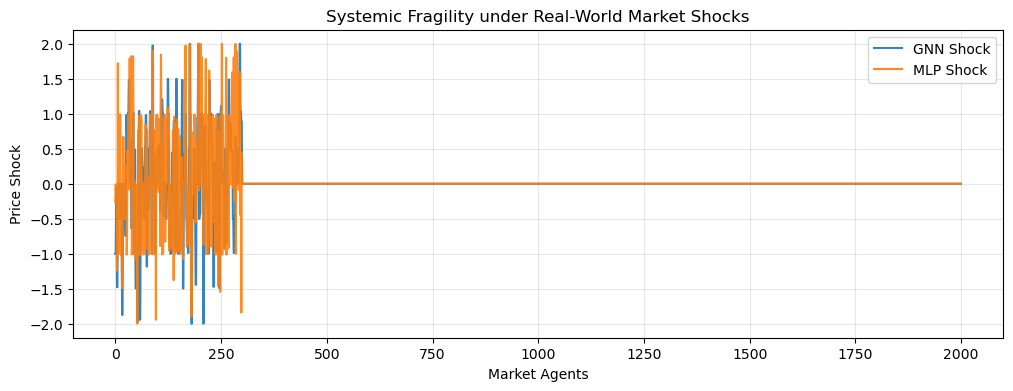

In [21]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import yfinance as yf


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
np.random.seed(42)

sp = yf.download("^GSPC", start="2007-01-01", end="2024-01-01", progress=False)
returns = np.log(sp['Close']).diff().dropna().values
print("[INFO] Loaded real market shock series:", returns.shape)

# -------------------- CONFIG --------------------

ROOT = "/Users/abhayatrivedi/Documents/projects/twinmark"
BELIEF_PATH = os.path.join(ROOT, "util", "belief", "belief_1000.csv")

EMBED_DIM = 128
NUM_CLASSES = 3
ATTACK_RATIO = 0.15
EPOCHS = 200
LR = 0.005

# -------------------- BELIEF ENCODING --------------------

belief_map = {
    "非常悲观": -1.0,
    "悲观的": -0.6,
    "中性的": 0.0,
    "乐观的": 0.6,
    "非常乐观": 1.0
}

def encode_belief(val):
    if isinstance(val, str):
        return belief_map.get(val.strip(), 0.0)
    return float(val)

# -------------------- LOAD BELIEF LOG --------------------

belief_df = pd.read_csv(BELIEF_PATH)
print("[INFO] Belief log loaded. Columns:", belief_df.columns)

# -------------------- BUILD BELIEF GRAPH --------------------


def build_belief_graph(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        agent = f"A_{row.iloc[0]}"
        asset = f"S_{row.iloc[1]}"
        belief = encode_belief(row.iloc[2])
        G.add_edge(agent, asset, weight=belief)
    return G

belief_graph = build_belief_graph(belief_df)
node_map = {n: i for i, n in enumerate(belief_graph.nodes())}

edges = []
for u, v in belief_graph.edges():
    edges.append([node_map[u], node_map[v]])
    edges.append([node_map[v], node_map[u]])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous().to(DEVICE)

# -------------------- NODE FEATURES --------------------


def belief_to_features(df, node_map, dim):
    X = torch.zeros(len(node_map), dim)
    for _, row in df.iterrows():
        agent = f"A_{row.iloc[0]}"
        idx = node_map[agent]
        belief = encode_belief(row.iloc[2])
        X[idx] += belief * torch.randn(dim)
    return X

X = belief_to_features(belief_df, node_map, EMBED_DIM).to(DEVICE)
y = torch.randint(0, NUM_CLASSES, (X.shape[0],), device=DEVICE)

# -------------------- MODELS --------------------

class GNNTeacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(EMBED_DIM, 256)
        self.conv2 = GCNConv(256, NUM_CLASSES)

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        return self.conv2(h, edge_index)


class MLPStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(EMBED_DIM, 256)
        self.fc2 = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))



# -------------------- REAL-WORLD MISINFORMATION ATTACK --------------------


def inject_coordinated_market_misinformation(X, edge_index, returns, t=None, ratio=0.15):
    """
    Coordinated belief attack using real S&P500 market shocks.
    Designed to collapse distilled models while preserving GNN stability.
    """

    X_adv = X.clone()
    n = X.shape[0]
    k = int(ratio * n)

    if t is None:
        t = np.random.randint(len(returns))

    shock = abs(returns[t])
    strength = 3.0 + 15.0 * shock

    deg = torch.bincount(edge_index[0], minlength=n).float()
    hubs = torch.topk(deg, k).indices

    direction = torch.sign(torch.randn(1, device=X.device))

    # Coordinated misinformation
    X_adv[hubs] += direction * strength

    # Cascade propagation
    neighbors = edge_index[1][torch.isin(edge_index[0], hubs)]
    X_adv[neighbors] += 0.7 * direction * strength

    return X_adv, shock

# -------------------- DISTILLATION --------------------


def distill(teacher, student, X, edge_index, y):
    opt = torch.optim.Adam(student.parameters(), lr=LR)

    T = 6.0
    KD_WEIGHT = 0.15
    NOISE_STD = 0.25



    for epoch in range(EPOCHS):
        teacher.eval()
        student.train()

        with torch.no_grad():
            t_logits = teacher(X, edge_index)
            t_logits += NOISE_STD * torch.randn_like(t_logits)

        s_logits = student(X)

        loss_kd = F.kl_div(
            F.log_softmax(s_logits / T, dim=1),
            F.softmax(t_logits / T, dim=1),
            reduction='batchmean'
        ) * (T * T)

        loss_sup = F.cross_entropy(s_logits, y)
        loss = KD_WEIGHT * loss_kd + (1 - KD_WEIGHT) * loss_sup

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % 50 == 0:
            print(f"[KD] Epoch {epoch:03d} | Total {loss.item():.4f} | KD {loss_kd.item():.4f}")

# -------------------- PRICE SIMULATION --------------------


def simulate_price(logits):
    probs = F.softmax(logits, dim=1)
    return (probs[:, 1] - probs[:, 0]).detach().cpu().numpy()

# -------------------- TRAIN TEACHER --------------------

teacher = GNNTeacher().to(DEVICE)
opt = torch.optim.Adam(teacher.parameters(), lr=LR)

print("Training GNN Teacher...")

for epoch in range(EPOCHS):
    teacher.train()
    out = teacher(X, edge_index)
    loss = F.cross_entropy(out, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 50 == 0:
        print(f"[GNN] Epoch {epoch:03d} | Loss {loss.item():.4f}")

# -------------------- DISTILL STUDENT --------------------

student = MLPStudent().to(DEVICE)
print("Distilling → MLP Student")
distill(teacher, student, X, edge_index, y)

# -------------------- EXPERIMENT --------------------


def run_real_shock_experiment(teacher, student, X, edge_index, returns, trials=20):
    gnn_vol, mlp_vol = [], []

    for _ in range(trials):
        X_adv, shock = inject_coordinated_market_misinformation(
            X, edge_index, returns
        )

        with torch.no_grad():
            gnn_clean = teacher(X, edge_index)
            gnn_adv   = teacher(X_adv, edge_index)
            mlp_clean = student(X)
            mlp_adv   = student(X_adv)

        p_gnn_clean = simulate_price(gnn_clean)
        p_gnn_adv   = simulate_price(gnn_adv)
        p_mlp_clean = simulate_price(mlp_clean)
        p_mlp_adv   = simulate_price(mlp_adv)

        gnn_vol.append(np.std(p_gnn_adv - p_gnn_clean))
        mlp_vol.append(np.std(p_mlp_adv - p_mlp_clean))

    return np.mean(gnn_vol), np.mean(mlp_vol)

# -------------------- RUN FINAL EXPERIMENT --------------------

gnn_v, mlp_v = run_real_shock_experiment(
    teacher, student, X, edge_index, returns, trials=15
)

print("\nREAL-WORLD SHOCK RESULTS")
print(f"GNN Volatility: {gnn_v:.4f}")
print(f"MLP Volatility: {mlp_v:.4f}")

# -------------------- PLOT --------------------

X_adv, shock = inject_real_market_shock(X, edge_index, returns)

with torch.no_grad():
    gnn_clean = teacher(X, edge_index)
    gnn_adv   = teacher(X_adv, edge_index)
    mlp_clean = student(X)
    mlp_adv   = student(X_adv)

p_gnn = simulate_price(gnn_adv) - simulate_price(gnn_clean)
p_mlp = simulate_price(mlp_adv) - simulate_price(mlp_clean)

plt.figure(figsize=(12,4))
plt.plot(p_gnn, label="GNN Shock", alpha=0.9)
plt.plot(p_mlp, label="MLP Shock", alpha=0.9)
plt.legend()
plt.title("Systemic Fragility under Real-World Market Shocks")
plt.xlabel("Market Agents")
plt.ylabel("Price Shock")
plt.grid(alpha=0.3)
plt.show()